# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 3.1MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

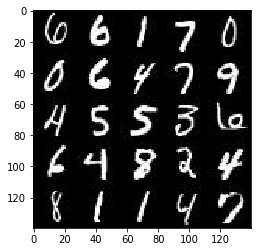

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

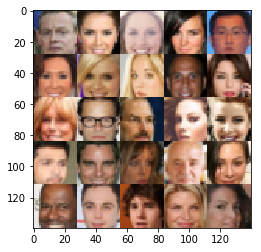

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    lr=tf.placeholder(dtype=tf.float32,name='learning_rate')
    input_image=tf.placeholder(dtype=tf.float32,shape=[None,image_width,image_height,image_channels],name='input_image')
    z=tf.placeholder(dtype=tf.float32,shape=[None,z_dim],name='z')

    return input_image, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False,training=True,alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        
        first_layer=tf.layers.conv2d(images,64,5,strides=2,padding='same',activation=None)
        first_layer=tf.maximum(first_layer,alpha*first_layer)
        
        second_layer=tf.layers.conv2d(first_layer,128,5,strides=2,padding='same',activation=None)
        second_layer=tf.layers.batch_normalization(second_layer,training=training)
        second_layer=tf.maximum(second_layer,alpha*second_layer)
        
        third_layer=tf.layers.conv2d(second_layer,256,5,strides=2,padding='same',activation=None)
        third_layer=tf.layers.batch_normalization(third_layer,training=training)
        third_layer=tf.maximum(third_layer,alpha*third_layer)
        
        forth_layer=tf.layers.conv2d(third_layer,512,5,strides=2,padding='same',activation=None)
        forth_layer=tf.layers.batch_normalization(forth_layer,training=training)
        forth_layer=tf.maximum(forth_layer,alpha*forth_layer)
        print("disc,,",forth_layer.shape)
        flatten = tf.reshape(forth_layer, (-1, 2*2*512))
        logits = tf.layers.dense(flatten,1)
        out =tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

disc,, (?, 2, 2, 512)
disc,, (?, 2, 2, 512)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        
        first_layer=tf.layers.dense(z,3*3*512)
        first_layer=tf.reshape(first_layer,(-1,3,3,512))
        first_layer=tf.layers.batch_normalization(first_layer,training=is_train)
        first_layer=tf.nn.relu(first_layer)
        
        second_layer=tf.layers.conv2d_transpose(first_layer,256,3,strides=2,padding='valid',activation=None)
        second_layer=tf.layers.batch_normalization(second_layer,training=is_train)
        second_layer=tf.nn.relu(second_layer)
        
        third_layer=tf.layers.conv2d_transpose(second_layer,128,5,strides=2,padding='same',activation=None)
        third_layer=tf.layers.batch_normalization(third_layer,training=is_train)
        third_layer=tf.nn.relu(third_layer)
        
        forth_layer=tf.layers.conv2d_transpose(third_layer,out_channel_dim,5,strides=2,padding='same',activation=None)
        forth_layer=tf.tanh(forth_layer)
#         print(forth_layer.shape)
        
        
    return forth_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_output=generator(input_z, out_channel_dim, is_train=True)
    d_true_label,d_true_logits=discriminator(input_real, reuse=False,alpha=alpha)
    d_fake_label,d_fake_logits=discriminator(generator_output, reuse=True,alpha=alpha)
    
    d_loss_real= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_true_logits,labels=tf.ones_like(d_true_label)))                   
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_label)))
    
    d_loss=d_loss_real+d_loss_fake
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.ones_like(d_fake_label)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

disc,, (?, 2, 2, 512)
disc,, (?, 2, 2, 512)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    g_vars=[trainable_var for trainable_var in tf.trainable_variables() if trainable_var.name.startswith('generator')]
    d_vars=[trainable_var for trainable_var in tf.trainable_variables() if trainable_var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_optimizer=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_optimizer,g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,alpha=0.2,print_every=10,show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real,input_z,lr=model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss=model_loss(input_real, input_z, data_shape[3])
    d_optimizer,g_optimizer=model_opt(d_loss, g_loss, lr, beta1)
    
    saver=tf.train.Saver()
    sample_z=np.random.uniform(-1,1,size=(10,z_dim))
    samples,losses=[],[]
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                #sample random noise for G
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                #run optimizer
                _=sess.run(d_optimizer,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                _=sess.run(g_optimizer,feed_dict={input_z:batch_z,input_real:batch_images,lr:learning_rate})
                if steps % print_every==0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d,train_loss_g))
                if steps%show_every==0:
                    show_generator_output(sess, 10, input_z, batch_images.shape[3], data_image_mode)
        saver.save(sess,'./checkpoints/generator.ckpt')
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

disc,, (?, 2, 2, 512)
disc,, (?, 2, 2, 512)
Epoch 1/2... Discriminator Loss: 0.1931... Generator Loss: 2.0714
Epoch 1/2... Discriminator Loss: 0.0338... Generator Loss: 7.1120
Epoch 1/2... Discriminator Loss: 0.1771... Generator Loss: 7.2937
Epoch 1/2... Discriminator Loss: 0.5056... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 0.0512... Generator Loss: 5.5292
Epoch 1/2... Discriminator Loss: 0.2648... Generator Loss: 5.3554
Epoch 1/2... Discriminator Loss: 0.2221... Generator Loss: 2.5169
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 1.7905
Epoch 1/2... Discriminator Loss: 0.1476... Generator Loss: 4.0376
Epoch 1/2... Discriminator Loss: 0.7227... Generator Loss: 0.9878


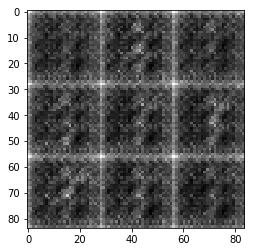

Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.3477
Epoch 1/2... Discriminator Loss: 0.3488... Generator Loss: 1.9826
Epoch 1/2... Discriminator Loss: 0.2439... Generator Loss: 2.4028
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 2.2356... Generator Loss: 0.1974
Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 1.6417
Epoch 1/2... Discriminator Loss: 0.1904... Generator Loss: 3.0004
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.5721
Epoch 1/2... Discriminator Loss: 0.1474... Generator Loss: 3.4291
Epoch 1/2... Discriminator Loss: 0.4378... Generator Loss: 1.3482


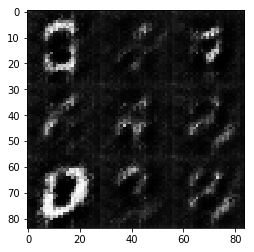

Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 1.2538
Epoch 1/2... Discriminator Loss: 3.2705... Generator Loss: 8.5128
Epoch 1/2... Discriminator Loss: 0.4301... Generator Loss: 1.4053
Epoch 1/2... Discriminator Loss: 0.4437... Generator Loss: 1.2375
Epoch 1/2... Discriminator Loss: 1.8994... Generator Loss: 0.4313
Epoch 1/2... Discriminator Loss: 0.2377... Generator Loss: 2.1467
Epoch 1/2... Discriminator Loss: 0.2403... Generator Loss: 2.2560
Epoch 1/2... Discriminator Loss: 0.5101... Generator Loss: 1.2556
Epoch 1/2... Discriminator Loss: 0.2291... Generator Loss: 2.2620
Epoch 1/2... Discriminator Loss: 0.1775... Generator Loss: 2.2134


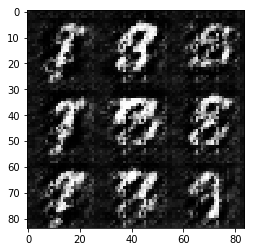

Epoch 1/2... Discriminator Loss: 0.1769... Generator Loss: 2.3752
Epoch 1/2... Discriminator Loss: 0.3709... Generator Loss: 1.3653
Epoch 1/2... Discriminator Loss: 0.0622... Generator Loss: 3.4164
Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 4.2035
Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 0.3081... Generator Loss: 1.7092
Epoch 1/2... Discriminator Loss: 0.2738... Generator Loss: 2.4790
Epoch 1/2... Discriminator Loss: 1.7332... Generator Loss: 0.2977
Epoch 1/2... Discriminator Loss: 0.3381... Generator Loss: 1.4124
Epoch 1/2... Discriminator Loss: 0.2009... Generator Loss: 2.1270


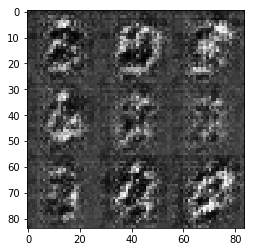

Epoch 1/2... Discriminator Loss: 1.5252... Generator Loss: 6.0481
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 0.6135
Epoch 1/2... Discriminator Loss: 0.3037... Generator Loss: 2.0280
Epoch 1/2... Discriminator Loss: 0.2894... Generator Loss: 3.9948
Epoch 1/2... Discriminator Loss: 0.2140... Generator Loss: 2.2286
Epoch 1/2... Discriminator Loss: 0.1142... Generator Loss: 2.9995
Epoch 1/2... Discriminator Loss: 0.2384... Generator Loss: 2.2245
Epoch 1/2... Discriminator Loss: 0.2346... Generator Loss: 2.2200
Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 1.1496
Epoch 1/2... Discriminator Loss: 0.2622... Generator Loss: 1.8227


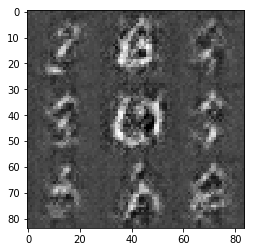

Epoch 1/2... Discriminator Loss: 0.1770... Generator Loss: 2.2620
Epoch 1/2... Discriminator Loss: 0.1958... Generator Loss: 2.2527
Epoch 1/2... Discriminator Loss: 0.0797... Generator Loss: 3.0882
Epoch 1/2... Discriminator Loss: 0.1428... Generator Loss: 2.5614
Epoch 1/2... Discriminator Loss: 0.2494... Generator Loss: 1.8188
Epoch 1/2... Discriminator Loss: 0.1014... Generator Loss: 2.8024
Epoch 1/2... Discriminator Loss: 0.0957... Generator Loss: 3.1947
Epoch 1/2... Discriminator Loss: 0.2233... Generator Loss: 2.1626
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.5528
Epoch 1/2... Discriminator Loss: 0.2213... Generator Loss: 2.2569


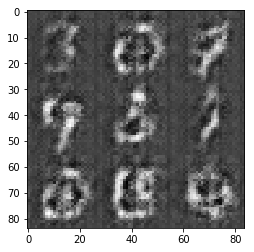

Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 4.4001
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.3706
Epoch 1/2... Discriminator Loss: 0.3387... Generator Loss: 1.5631
Epoch 1/2... Discriminator Loss: 0.3675... Generator Loss: 1.4490
Epoch 1/2... Discriminator Loss: 0.4230... Generator Loss: 1.2859
Epoch 1/2... Discriminator Loss: 0.2539... Generator Loss: 1.9256
Epoch 1/2... Discriminator Loss: 0.2183... Generator Loss: 1.9394
Epoch 1/2... Discriminator Loss: 0.1444... Generator Loss: 2.3638
Epoch 1/2... Discriminator Loss: 0.1589... Generator Loss: 2.4442
Epoch 1/2... Discriminator Loss: 0.2422... Generator Loss: 2.0132


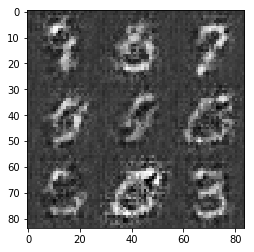

Epoch 1/2... Discriminator Loss: 0.0602... Generator Loss: 3.8126
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 1.1348
Epoch 1/2... Discriminator Loss: 0.3783... Generator Loss: 7.4146
Epoch 1/2... Discriminator Loss: 0.2504... Generator Loss: 1.9882
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 0.2627... Generator Loss: 1.6748
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 1.1556
Epoch 1/2... Discriminator Loss: 0.1271... Generator Loss: 2.4435
Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 0.0933... Generator Loss: 2.9359


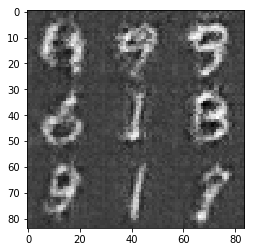

Epoch 1/2... Discriminator Loss: 0.0344... Generator Loss: 4.4935
Epoch 1/2... Discriminator Loss: 0.1804... Generator Loss: 2.1134
Epoch 1/2... Discriminator Loss: 0.2534... Generator Loss: 1.8499
Epoch 1/2... Discriminator Loss: 0.1227... Generator Loss: 2.5199
Epoch 1/2... Discriminator Loss: 0.0660... Generator Loss: 3.4238
Epoch 1/2... Discriminator Loss: 0.0209... Generator Loss: 4.8175
Epoch 1/2... Discriminator Loss: 0.0610... Generator Loss: 4.9436
Epoch 1/2... Discriminator Loss: 0.0354... Generator Loss: 3.9063
Epoch 1/2... Discriminator Loss: 0.1209... Generator Loss: 2.5887
Epoch 1/2... Discriminator Loss: 0.0589... Generator Loss: 3.4000


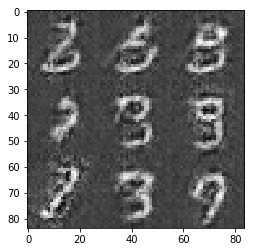

Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 6.7834
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.7630
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 0.4282... Generator Loss: 1.6633
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 1.3284
Epoch 1/2... Discriminator Loss: 0.5187... Generator Loss: 1.4218
Epoch 1/2... Discriminator Loss: 0.3417... Generator Loss: 1.7039
Epoch 1/2... Discriminator Loss: 0.2487... Generator Loss: 2.1595
Epoch 1/2... Discriminator Loss: 0.6020... Generator Loss: 2.8410
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 1.3697


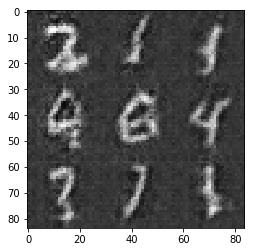

Epoch 1/2... Discriminator Loss: 0.1929... Generator Loss: 2.2421
Epoch 1/2... Discriminator Loss: 0.3014... Generator Loss: 2.9047
Epoch 1/2... Discriminator Loss: 0.4668... Generator Loss: 1.1874
Epoch 1/2... Discriminator Loss: 0.3448... Generator Loss: 1.6083
Epoch 1/2... Discriminator Loss: 0.2836... Generator Loss: 1.7485
Epoch 1/2... Discriminator Loss: 0.3288... Generator Loss: 1.5213
Epoch 1/2... Discriminator Loss: 0.1474... Generator Loss: 2.3346
Epoch 1/2... Discriminator Loss: 0.1735... Generator Loss: 2.1857
Epoch 1/2... Discriminator Loss: 0.1282... Generator Loss: 2.7610
Epoch 1/2... Discriminator Loss: 0.1846... Generator Loss: 2.0745


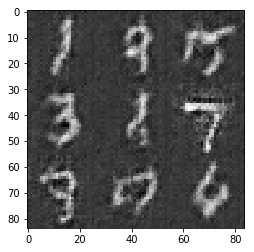

Epoch 1/2... Discriminator Loss: 0.1663... Generator Loss: 2.3760
Epoch 1/2... Discriminator Loss: 0.0983... Generator Loss: 2.7422
Epoch 1/2... Discriminator Loss: 0.0629... Generator Loss: 3.2506
Epoch 1/2... Discriminator Loss: 1.8011... Generator Loss: 0.2896
Epoch 1/2... Discriminator Loss: 0.1931... Generator Loss: 2.1137
Epoch 1/2... Discriminator Loss: 2.7484... Generator Loss: 4.6711
Epoch 1/2... Discriminator Loss: 0.4045... Generator Loss: 1.6099
Epoch 1/2... Discriminator Loss: 0.2573... Generator Loss: 1.9339
Epoch 1/2... Discriminator Loss: 0.2521... Generator Loss: 2.3599
Epoch 1/2... Discriminator Loss: 0.1296... Generator Loss: 2.6717


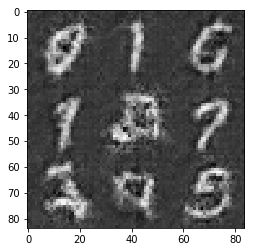

Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 1.5411
Epoch 1/2... Discriminator Loss: 0.2149... Generator Loss: 2.3129
Epoch 1/2... Discriminator Loss: 0.0562... Generator Loss: 3.3051
Epoch 1/2... Discriminator Loss: 0.1110... Generator Loss: 2.6190
Epoch 1/2... Discriminator Loss: 0.1185... Generator Loss: 2.4791
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 0.0449... Generator Loss: 3.6163
Epoch 1/2... Discriminator Loss: 0.0199... Generator Loss: 4.4845
Epoch 1/2... Discriminator Loss: 0.0061... Generator Loss: 5.8436
Epoch 1/2... Discriminator Loss: 0.0129... Generator Loss: 5.2507


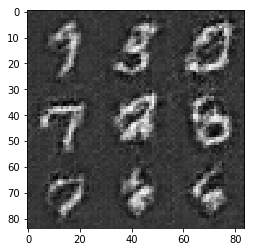

Epoch 1/2... Discriminator Loss: 0.0158... Generator Loss: 5.1498
Epoch 1/2... Discriminator Loss: 0.0181... Generator Loss: 5.8519
Epoch 1/2... Discriminator Loss: 0.0480... Generator Loss: 3.4278
Epoch 1/2... Discriminator Loss: 0.0450... Generator Loss: 3.5810
Epoch 1/2... Discriminator Loss: 0.0557... Generator Loss: 3.5474
Epoch 1/2... Discriminator Loss: 0.0118... Generator Loss: 5.7513
Epoch 1/2... Discriminator Loss: 0.0403... Generator Loss: 3.6501
Epoch 1/2... Discriminator Loss: 0.0256... Generator Loss: 5.5992
Epoch 1/2... Discriminator Loss: 5.7547... Generator Loss: 6.0939
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.7941


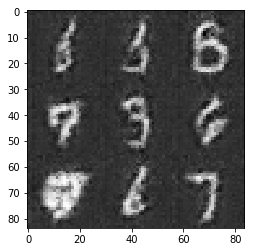

Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 0.9552
Epoch 1/2... Discriminator Loss: 0.8820... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 2.7047
Epoch 1/2... Discriminator Loss: 0.1267... Generator Loss: 2.3772
Epoch 1/2... Discriminator Loss: 0.2624... Generator Loss: 2.6528
Epoch 1/2... Discriminator Loss: 0.0771... Generator Loss: 4.4176
Epoch 1/2... Discriminator Loss: 0.1110... Generator Loss: 2.6073
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.4093


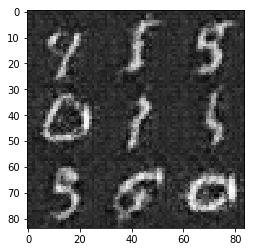

Epoch 1/2... Discriminator Loss: 0.3274... Generator Loss: 2.8671
Epoch 1/2... Discriminator Loss: 0.0652... Generator Loss: 3.2469
Epoch 1/2... Discriminator Loss: 0.0878... Generator Loss: 2.8078
Epoch 1/2... Discriminator Loss: 0.2600... Generator Loss: 1.7337
Epoch 1/2... Discriminator Loss: 0.0372... Generator Loss: 4.0591
Epoch 1/2... Discriminator Loss: 0.0970... Generator Loss: 2.7587
Epoch 1/2... Discriminator Loss: 0.1344... Generator Loss: 2.3855
Epoch 1/2... Discriminator Loss: 0.0416... Generator Loss: 3.6871
Epoch 1/2... Discriminator Loss: 0.0662... Generator Loss: 3.2764
Epoch 1/2... Discriminator Loss: 0.1293... Generator Loss: 2.4218


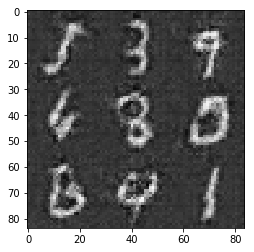

Epoch 1/2... Discriminator Loss: 0.0223... Generator Loss: 4.3809
Epoch 1/2... Discriminator Loss: 0.0924... Generator Loss: 2.9330
Epoch 1/2... Discriminator Loss: 0.0278... Generator Loss: 3.9957
Epoch 1/2... Discriminator Loss: 0.0366... Generator Loss: 3.7796
Epoch 1/2... Discriminator Loss: 0.0359... Generator Loss: 4.0225
Epoch 1/2... Discriminator Loss: 0.0281... Generator Loss: 3.8347
Epoch 1/2... Discriminator Loss: 0.1663... Generator Loss: 2.2366
Epoch 1/2... Discriminator Loss: 0.0690... Generator Loss: 3.1781
Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 4.9214
Epoch 1/2... Discriminator Loss: 0.0079... Generator Loss: 5.5507


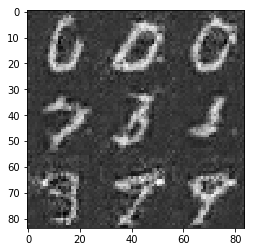

Epoch 1/2... Discriminator Loss: 0.0243... Generator Loss: 4.3675
Epoch 1/2... Discriminator Loss: 0.0844... Generator Loss: 3.3222
Epoch 1/2... Discriminator Loss: 0.0058... Generator Loss: 6.1583
Epoch 1/2... Discriminator Loss: 0.2134... Generator Loss: 1.9804
Epoch 1/2... Discriminator Loss: 1.6474... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 0.6716... Generator Loss: 1.2305
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 1.3709
Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 0.5279... Generator Loss: 1.0972
Epoch 1/2... Discriminator Loss: 0.2713... Generator Loss: 1.6411


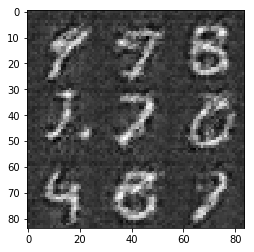

Epoch 1/2... Discriminator Loss: 0.2022... Generator Loss: 2.4245
Epoch 1/2... Discriminator Loss: 0.1921... Generator Loss: 2.9048
Epoch 1/2... Discriminator Loss: 0.3042... Generator Loss: 1.5359
Epoch 1/2... Discriminator Loss: 2.0023... Generator Loss: 6.2901
Epoch 1/2... Discriminator Loss: 0.3653... Generator Loss: 1.5011
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 4.0504
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 1.7191
Epoch 2/2... Discriminator Loss: 0.1593... Generator Loss: 2.1904
Epoch 2/2... Discriminator Loss: 0.2568... Generator Loss: 1.7206
Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 3.1098


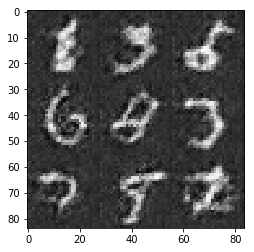

Epoch 2/2... Discriminator Loss: 0.3681... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 0.1789... Generator Loss: 2.1612
Epoch 2/2... Discriminator Loss: 4.3551... Generator Loss: 0.0257
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.0787
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 1.5069... Generator Loss: 3.6923
Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 2.5187
Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 0.6872


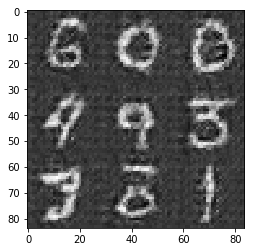

Epoch 2/2... Discriminator Loss: 0.3224... Generator Loss: 1.6578
Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 1.4783
Epoch 2/2... Discriminator Loss: 0.4095... Generator Loss: 1.3095
Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 5.2204
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 2.1435
Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 0.5646... Generator Loss: 4.1759
Epoch 2/2... Discriminator Loss: 0.4462... Generator Loss: 1.2595
Epoch 2/2... Discriminator Loss: 0.4407... Generator Loss: 1.2883


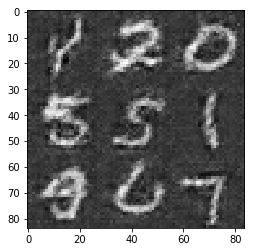

Epoch 2/2... Discriminator Loss: 0.2978... Generator Loss: 3.8979
Epoch 2/2... Discriminator Loss: 0.2622... Generator Loss: 3.0667
Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 1.2706
Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 0.9608
Epoch 2/2... Discriminator Loss: 0.1963... Generator Loss: 1.9366
Epoch 2/2... Discriminator Loss: 0.1816... Generator Loss: 1.9221
Epoch 2/2... Discriminator Loss: 0.2461... Generator Loss: 1.7637
Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 1.3805
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 1.4668
Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 3.1652


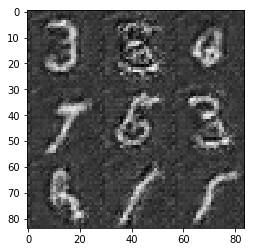

Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 2.8756
Epoch 2/2... Discriminator Loss: 0.0804... Generator Loss: 2.9988
Epoch 2/2... Discriminator Loss: 0.1607... Generator Loss: 2.1810
Epoch 2/2... Discriminator Loss: 0.1478... Generator Loss: 2.2955
Epoch 2/2... Discriminator Loss: 0.0814... Generator Loss: 2.9484
Epoch 2/2... Discriminator Loss: 0.0936... Generator Loss: 2.6307
Epoch 2/2... Discriminator Loss: 0.0765... Generator Loss: 2.9005
Epoch 2/2... Discriminator Loss: 0.1202... Generator Loss: 2.5456
Epoch 2/2... Discriminator Loss: 0.4892... Generator Loss: 1.2571
Epoch 2/2... Discriminator Loss: 0.1706... Generator Loss: 2.2342


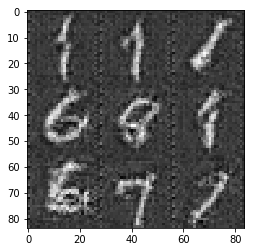

Epoch 2/2... Discriminator Loss: 0.0939... Generator Loss: 2.7421
Epoch 2/2... Discriminator Loss: 0.0670... Generator Loss: 3.0866
Epoch 2/2... Discriminator Loss: 0.1472... Generator Loss: 2.3436
Epoch 2/2... Discriminator Loss: 0.0976... Generator Loss: 2.7106
Epoch 2/2... Discriminator Loss: 0.0088... Generator Loss: 5.5672
Epoch 2/2... Discriminator Loss: 0.0312... Generator Loss: 4.0026
Epoch 2/2... Discriminator Loss: 0.1501... Generator Loss: 2.3441
Epoch 2/2... Discriminator Loss: 4.7262... Generator Loss: 10.0217
Epoch 2/2... Discriminator Loss: 0.1657... Generator Loss: 2.3670
Epoch 2/2... Discriminator Loss: 0.1400... Generator Loss: 2.3521


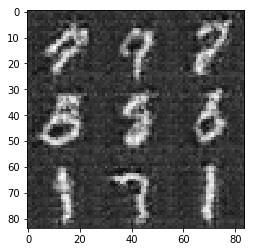

Epoch 2/2... Discriminator Loss: 0.0802... Generator Loss: 3.4222
Epoch 2/2... Discriminator Loss: 0.3231... Generator Loss: 3.6170
Epoch 2/2... Discriminator Loss: 0.2214... Generator Loss: 1.9530
Epoch 2/2... Discriminator Loss: 0.2908... Generator Loss: 1.6202
Epoch 2/2... Discriminator Loss: 0.1962... Generator Loss: 2.0206
Epoch 2/2... Discriminator Loss: 0.1072... Generator Loss: 3.0116
Epoch 2/2... Discriminator Loss: 0.0933... Generator Loss: 2.7197
Epoch 2/2... Discriminator Loss: 0.2117... Generator Loss: 1.8883
Epoch 2/2... Discriminator Loss: 0.3250... Generator Loss: 1.4578
Epoch 2/2... Discriminator Loss: 0.2554... Generator Loss: 1.7123


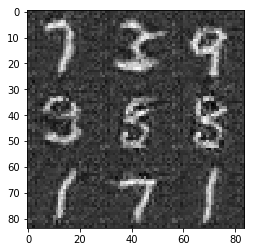

Epoch 2/2... Discriminator Loss: 0.0293... Generator Loss: 4.0238
Epoch 2/2... Discriminator Loss: 0.1672... Generator Loss: 2.1400
Epoch 2/2... Discriminator Loss: 0.2015... Generator Loss: 2.0381
Epoch 2/2... Discriminator Loss: 0.0104... Generator Loss: 5.0698
Epoch 2/2... Discriminator Loss: 0.1471... Generator Loss: 2.3344
Epoch 2/2... Discriminator Loss: 0.0456... Generator Loss: 3.7085
Epoch 2/2... Discriminator Loss: 0.0187... Generator Loss: 4.6133
Epoch 2/2... Discriminator Loss: 0.1383... Generator Loss: 2.4885
Epoch 2/2... Discriminator Loss: 0.0426... Generator Loss: 3.5594
Epoch 2/2... Discriminator Loss: 0.0621... Generator Loss: 2.9816


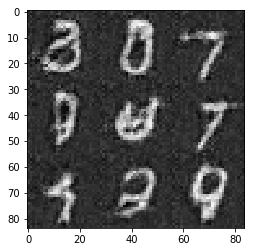

Epoch 2/2... Discriminator Loss: 0.0613... Generator Loss: 3.2489
Epoch 2/2... Discriminator Loss: 0.0314... Generator Loss: 4.0266
Epoch 2/2... Discriminator Loss: 0.1853... Generator Loss: 2.1202
Epoch 2/2... Discriminator Loss: 0.0807... Generator Loss: 2.9421
Epoch 2/2... Discriminator Loss: 0.0289... Generator Loss: 4.2041
Epoch 2/2... Discriminator Loss: 0.0208... Generator Loss: 4.7201
Epoch 2/2... Discriminator Loss: 0.0034... Generator Loss: 7.6772
Epoch 2/2... Discriminator Loss: 0.0774... Generator Loss: 3.0227
Epoch 2/2... Discriminator Loss: 0.0776... Generator Loss: 3.0845
Epoch 2/2... Discriminator Loss: 0.0054... Generator Loss: 5.7046


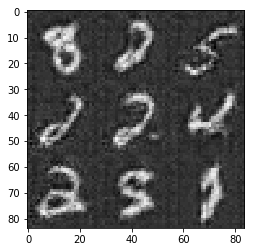

Epoch 2/2... Discriminator Loss: 0.0971... Generator Loss: 2.8136
Epoch 2/2... Discriminator Loss: 0.0370... Generator Loss: 3.6977
Epoch 2/2... Discriminator Loss: 0.0510... Generator Loss: 3.2647
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.1704
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 1.5947
Epoch 2/2... Discriminator Loss: 0.3509... Generator Loss: 2.2246
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 0.9987
Epoch 2/2... Discriminator Loss: 0.3071... Generator Loss: 1.5812
Epoch 2/2... Discriminator Loss: 2.0681... Generator Loss: 5.9548


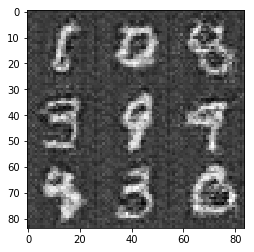

Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 2.5560
Epoch 2/2... Discriminator Loss: 0.7472... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 0.3056... Generator Loss: 2.7995
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 0.8553
Epoch 2/2... Discriminator Loss: 0.2295... Generator Loss: 1.7924
Epoch 2/2... Discriminator Loss: 0.2183... Generator Loss: 5.3931
Epoch 2/2... Discriminator Loss: 0.1035... Generator Loss: 3.0052
Epoch 2/2... Discriminator Loss: 1.6835... Generator Loss: 0.2648
Epoch 2/2... Discriminator Loss: 0.2104... Generator Loss: 1.9781


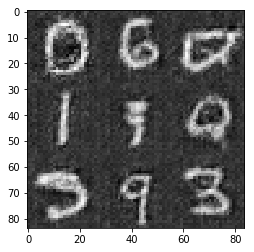

Epoch 2/2... Discriminator Loss: 0.0712... Generator Loss: 4.1658
Epoch 2/2... Discriminator Loss: 0.2549... Generator Loss: 1.7206
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 7.6876
Epoch 2/2... Discriminator Loss: 0.0541... Generator Loss: 3.7129
Epoch 2/2... Discriminator Loss: 1.1911... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 0.4796... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 0.1977... Generator Loss: 2.0488
Epoch 2/2... Discriminator Loss: 0.4683... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 0.0970... Generator Loss: 2.6926
Epoch 2/2... Discriminator Loss: 0.0661... Generator Loss: 3.0217


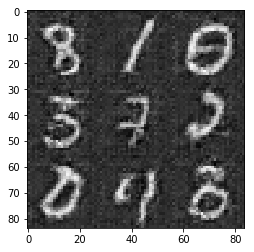

Epoch 2/2... Discriminator Loss: 0.0458... Generator Loss: 3.6946
Epoch 2/2... Discriminator Loss: 0.1483... Generator Loss: 2.4459
Epoch 2/2... Discriminator Loss: 0.0094... Generator Loss: 5.0516
Epoch 2/2... Discriminator Loss: 6.7700... Generator Loss: 9.2395
Epoch 2/2... Discriminator Loss: 0.3492... Generator Loss: 1.6881
Epoch 2/2... Discriminator Loss: 0.7016... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 0.4102... Generator Loss: 1.4933
Epoch 2/2... Discriminator Loss: 0.3050... Generator Loss: 1.5370
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.5959
Epoch 2/2... Discriminator Loss: 0.1875... Generator Loss: 1.9308


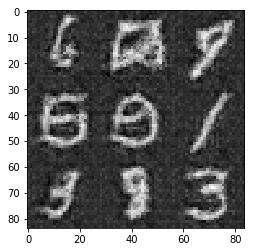

Epoch 2/2... Discriminator Loss: 0.4180... Generator Loss: 1.2965
Epoch 2/2... Discriminator Loss: 4.6106... Generator Loss: 0.0177
Epoch 2/2... Discriminator Loss: 0.6563... Generator Loss: 6.1395
Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 1.1267
Epoch 2/2... Discriminator Loss: 0.4179... Generator Loss: 1.2776
Epoch 2/2... Discriminator Loss: 0.4404... Generator Loss: 1.2316
Epoch 2/2... Discriminator Loss: 1.4326... Generator Loss: 0.3320
Epoch 2/2... Discriminator Loss: 0.3616... Generator Loss: 1.3174
Epoch 2/2... Discriminator Loss: 1.7873... Generator Loss: 8.0628
Epoch 2/2... Discriminator Loss: 0.0321... Generator Loss: 4.3484


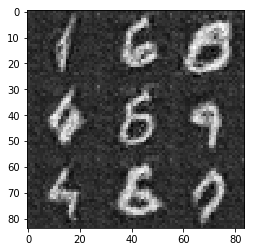

Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.4125
Epoch 2/2... Discriminator Loss: 0.4562... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 0.0857... Generator Loss: 2.7849
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 0.9926
Epoch 2/2... Discriminator Loss: 0.1005... Generator Loss: 2.8650
Epoch 2/2... Discriminator Loss: 0.4542... Generator Loss: 1.2483
Epoch 2/2... Discriminator Loss: 0.1312... Generator Loss: 2.4139
Epoch 2/2... Discriminator Loss: 0.1480... Generator Loss: 2.2302
Epoch 2/2... Discriminator Loss: 0.0639... Generator Loss: 3.1209
Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 1.3917


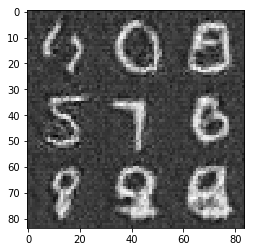

Epoch 2/2... Discriminator Loss: 0.0284... Generator Loss: 3.8593
Epoch 2/2... Discriminator Loss: 0.2344... Generator Loss: 1.8941
Epoch 2/2... Discriminator Loss: 0.0588... Generator Loss: 3.0608
Epoch 2/2... Discriminator Loss: 0.5786... Generator Loss: 1.0320
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 0.8071
Epoch 2/2... Discriminator Loss: 0.1092... Generator Loss: 2.7516
Epoch 2/2... Discriminator Loss: 0.1850... Generator Loss: 2.0834
Epoch 2/2... Discriminator Loss: 0.0290... Generator Loss: 3.9498
Epoch 2/2... Discriminator Loss: 0.0336... Generator Loss: 3.6358
Epoch 2/2... Discriminator Loss: 0.0461... Generator Loss: 3.8064


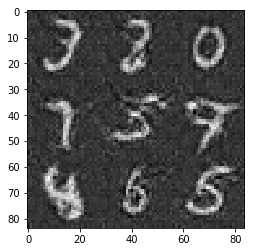

Epoch 2/2... Discriminator Loss: 0.0695... Generator Loss: 2.9487
Epoch 2/2... Discriminator Loss: 0.0205... Generator Loss: 4.3132
Epoch 2/2... Discriminator Loss: 0.0031... Generator Loss: 6.4628
Epoch 2/2... Discriminator Loss: 0.0296... Generator Loss: 3.9967
Epoch 2/2... Discriminator Loss: 0.0226... Generator Loss: 4.2910
Epoch 2/2... Discriminator Loss: 0.1281... Generator Loss: 2.5051
Epoch 2/2... Discriminator Loss: 0.0348... Generator Loss: 3.7488
Epoch 2/2... Discriminator Loss: 0.0854... Generator Loss: 2.7468
Epoch 2/2... Discriminator Loss: 0.0562... Generator Loss: 3.3282
Epoch 2/2... Discriminator Loss: 0.0128... Generator Loss: 4.7561


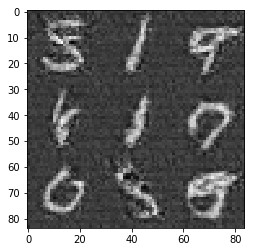

Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 5.7509... Generator Loss: 0.0107
Epoch 2/2... Discriminator Loss: 0.1431... Generator Loss: 2.3357
Epoch 2/2... Discriminator Loss: 0.1420... Generator Loss: 2.5007
Epoch 2/2... Discriminator Loss: 0.1290... Generator Loss: 2.4534
Epoch 2/2... Discriminator Loss: 0.0250... Generator Loss: 4.2554
Epoch 2/2... Discriminator Loss: 0.3352... Generator Loss: 1.3941
Epoch 2/2... Discriminator Loss: 0.1223... Generator Loss: 2.3707
Epoch 2/2... Discriminator Loss: 0.0909... Generator Loss: 2.8836
Epoch 2/2... Discriminator Loss: 0.1920... Generator Loss: 2.1032


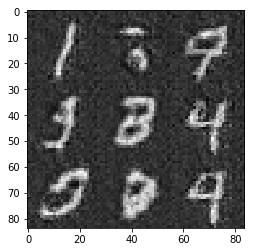

Epoch 2/2... Discriminator Loss: 0.3891... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 3.9660... Generator Loss: 0.0301
Epoch 2/2... Discriminator Loss: 0.3173... Generator Loss: 1.5749
Epoch 2/2... Discriminator Loss: 0.2112... Generator Loss: 2.0334
Epoch 2/2... Discriminator Loss: 0.1637... Generator Loss: 2.3604
Epoch 2/2... Discriminator Loss: 0.3663... Generator Loss: 1.3311
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 7.0535
Epoch 2/2... Discriminator Loss: 0.1780... Generator Loss: 2.0269
Epoch 2/2... Discriminator Loss: 0.2653... Generator Loss: 1.6889
Epoch 2/2... Discriminator Loss: 0.0818... Generator Loss: 2.9688


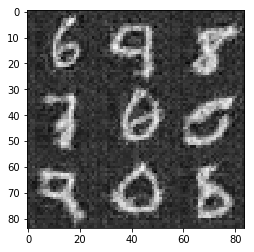

Epoch 2/2... Discriminator Loss: 0.6512... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 0.2096... Generator Loss: 1.8497
Epoch 2/2... Discriminator Loss: 0.0388... Generator Loss: 3.7843
Epoch 2/2... Discriminator Loss: 0.1343... Generator Loss: 2.7017
Epoch 2/2... Discriminator Loss: 0.1595... Generator Loss: 2.2850


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

disc,, (?, 2, 2, 512)
disc,, (?, 2, 2, 512)
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 2.0249
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.3804
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 15.1150
Epoch 1/1... Discriminator Loss: 2.7744... Generator Loss: 0.1136
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 11.4400
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 1.4093
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 4.9091


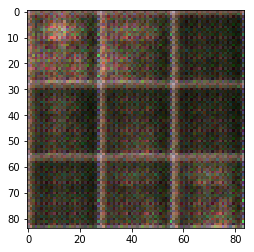

Epoch 1/1... Discriminator Loss: 0.2270... Generator Loss: 2.4293
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 5.1004
Epoch 1/1... Discriminator Loss: 0.1303... Generator Loss: 3.2853
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 0.3059... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 2.0493... Generator Loss: 0.2271
Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 7.4211
Epoch 1/1... Discriminator Loss: 0.2376... Generator Loss: 1.8008
Epoch 1/1... Discriminator Loss: 0.2822... Generator Loss: 2.3061
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 2.4747


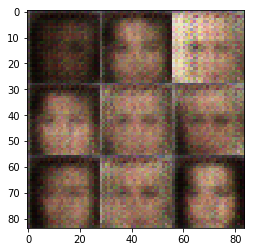

Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 0.1428... Generator Loss: 2.4258
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 0.1050... Generator Loss: 4.8903
Epoch 1/1... Discriminator Loss: 0.0713... Generator Loss: 3.8590
Epoch 1/1... Discriminator Loss: 0.2152... Generator Loss: 2.2703
Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 8.9900
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 4.8673
Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 4.3793


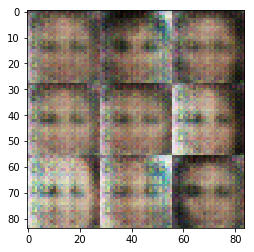

Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 4.0753
Epoch 1/1... Discriminator Loss: 0.1653... Generator Loss: 2.5939
Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 5.2548
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 7.5682
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 0.0440... Generator Loss: 6.1556


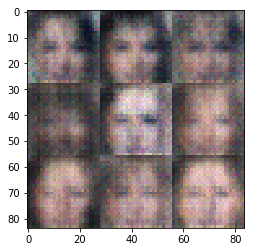

Epoch 1/1... Discriminator Loss: 0.1678... Generator Loss: 3.0425
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 2.6863
Epoch 1/1... Discriminator Loss: 0.2855... Generator Loss: 2.4778
Epoch 1/1... Discriminator Loss: 0.3328... Generator Loss: 2.6655
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 1.3110
Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 3.4422
Epoch 1/1... Discriminator Loss: 0.1120... Generator Loss: 3.9523
Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 1.5669
Epoch 1/1... Discriminator Loss: 2.1085... Generator Loss: 0.2115
Epoch 1/1... Discriminator Loss: 0.0226... Generator Loss: 4.1920


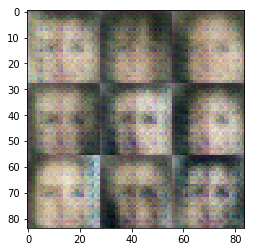

Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 4.5405
Epoch 1/1... Discriminator Loss: 0.4412... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 9.5108
Epoch 1/1... Discriminator Loss: 0.1317... Generator Loss: 3.8960
Epoch 1/1... Discriminator Loss: 2.2312... Generator Loss: 0.1813
Epoch 1/1... Discriminator Loss: 0.1889... Generator Loss: 2.0708
Epoch 1/1... Discriminator Loss: 0.1032... Generator Loss: 3.4133
Epoch 1/1... Discriminator Loss: 0.0747... Generator Loss: 2.8886
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 3.8894
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 3.4669


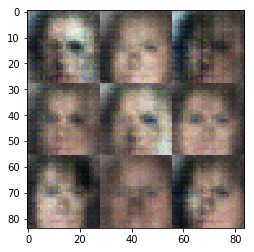

Epoch 1/1... Discriminator Loss: 0.2530... Generator Loss: 1.7127
Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 6.1066
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 4.2002
Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 3.9501
Epoch 1/1... Discriminator Loss: 0.0868... Generator Loss: 4.2353
Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 8.3601
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 5.2352
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 9.3990
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 9.3492


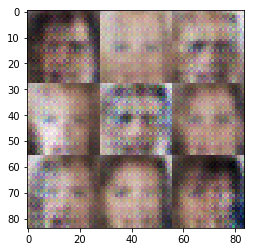

Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 7.8076
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.9209
Epoch 1/1... Discriminator Loss: 0.1932... Generator Loss: 4.1270
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 3.1218
Epoch 1/1... Discriminator Loss: 0.3151... Generator Loss: 2.2225
Epoch 1/1... Discriminator Loss: 0.2856... Generator Loss: 1.6429
Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 4.5889
Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 4.5047
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 3.3728
Epoch 1/1... Discriminator Loss: 0.1646... Generator Loss: 5.0907


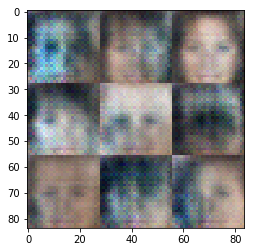

Epoch 1/1... Discriminator Loss: 2.5173... Generator Loss: 6.6140
Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 5.9481
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 3.0608
Epoch 1/1... Discriminator Loss: 0.0476... Generator Loss: 6.6887
Epoch 1/1... Discriminator Loss: 0.1544... Generator Loss: 2.1814
Epoch 1/1... Discriminator Loss: 0.0105... Generator Loss: 6.8503
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 2.4153
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 6.5198
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 7.3241
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 7.7146


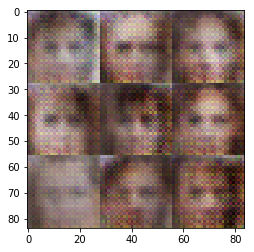

Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 6.5933
Epoch 1/1... Discriminator Loss: 0.0993... Generator Loss: 2.5771
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 8.7062
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.3650
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 6.8540
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 9.0809
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 9.1217
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.7166
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.6510
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.6185


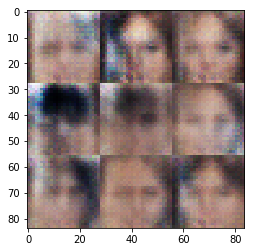

Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 4.3514
Epoch 1/1... Discriminator Loss: 4.7148... Generator Loss: 8.8283
Epoch 1/1... Discriminator Loss: 0.2856... Generator Loss: 1.6188
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 6.0343
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 7.2046
Epoch 1/1... Discriminator Loss: 0.0882... Generator Loss: 2.7239
Epoch 1/1... Discriminator Loss: 0.1215... Generator Loss: 4.8195
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 4.3783
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.4848


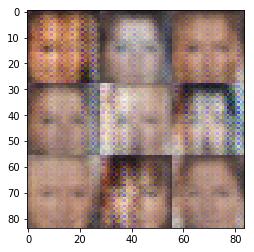

Epoch 1/1... Discriminator Loss: 0.1375... Generator Loss: 2.4088
Epoch 1/1... Discriminator Loss: 2.0803... Generator Loss: 0.2008
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 2.4581
Epoch 1/1... Discriminator Loss: 0.1948... Generator Loss: 2.0192
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 6.4478
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 7.2025
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 3.1267
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 8.4590
Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 5.0257


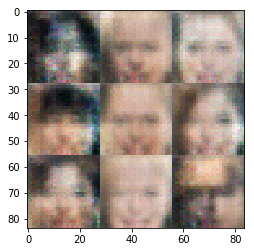

Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.4086
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.5832
Epoch 1/1... Discriminator Loss: 4.3192... Generator Loss: 0.0163
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 3.2989
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 3.6104
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 5.5462


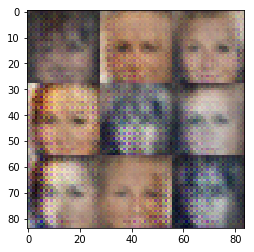

Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 5.3548
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 6.2163
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 6.9795
Epoch 1/1... Discriminator Loss: 0.3146... Generator Loss: 6.3827
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 5.6192
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 8.3413
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 7.9876
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.2657
Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 5.4908


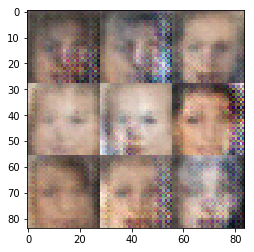

Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 8.5328
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 7.1994
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 8.0928
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 6.4947
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.6073
Epoch 1/1... Discriminator Loss: 2.6824... Generator Loss: 0.0868
Epoch 1/1... Discriminator Loss: 3.7789... Generator Loss: 0.0315
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 5.4015
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 7.6215


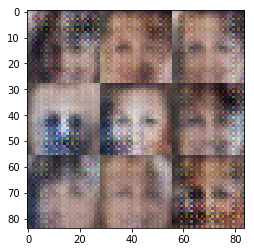

Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 7.1165
Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 0.2627
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 5.5255
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 7.0852
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 6.2111
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 5.1856
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 5.2512
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 3.7145
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 6.5587
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 0.8383


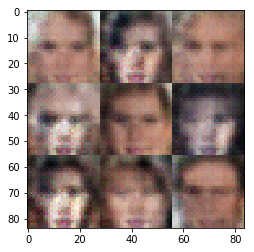

Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 5.5403
Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 3.9433
Epoch 1/1... Discriminator Loss: 0.1433... Generator Loss: 2.2431
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 8.7013
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 8.5859
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.8041
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 8.6392
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 5.6794
Epoch 1/1... Discriminator Loss: 0.1118... Generator Loss: 2.6987
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 0.5713


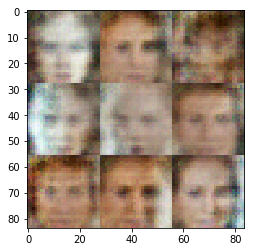

Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 6.5847
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 5.6564
Epoch 1/1... Discriminator Loss: 0.2531... Generator Loss: 3.6143
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 6.0633
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 4.8262
Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 6.2873
Epoch 1/1... Discriminator Loss: 3.2979... Generator Loss: 3.4437
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 6.4104
Epoch 1/1... Discriminator Loss: 0.0869... Generator Loss: 3.1226
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 5.3443


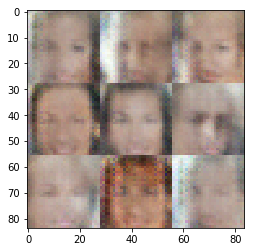

Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.5059
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 5.7075
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 7.2239
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.9140
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.3739
Epoch 1/1... Discriminator Loss: 0.1612... Generator Loss: 2.0012
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 5.1300
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 7.8574
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 7.1462


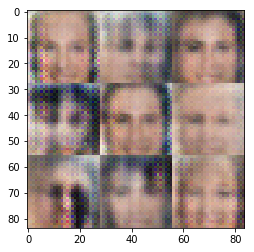

Epoch 1/1... Discriminator Loss: 0.2964... Generator Loss: 1.5459
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 3.3441
Epoch 1/1... Discriminator Loss: 0.0557... Generator Loss: 6.1773
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 2.1934
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 7.2102
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 6.7938
Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 6.5559
Epoch 1/1... Discriminator Loss: 3.1515... Generator Loss: 7.1534


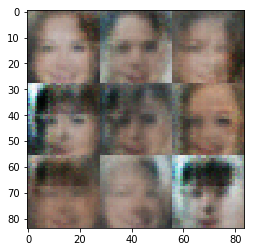

Epoch 1/1... Discriminator Loss: 0.0485... Generator Loss: 6.7958
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 7.5870
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 7.1767
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 6.4196
Epoch 1/1... Discriminator Loss: 0.2261... Generator Loss: 1.8787
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 6.9848
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 7.6700
Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 6.5974
Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 3.0321
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.6794


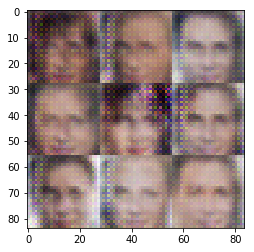

Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.4952
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 8.7890
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 8.6295
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 8.4953
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 8.2097
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 7.4554
Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 6.7246
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 8.1808
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 8.4372
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 8.0217


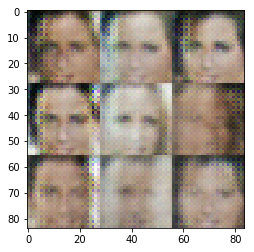

Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 3.1661
Epoch 1/1... Discriminator Loss: 0.1774... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 5.7308
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 6.5736
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 7.7762
Epoch 1/1... Discriminator Loss: 0.1698... Generator Loss: 1.9581
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 6.1142
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 5.6723
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 5.5023


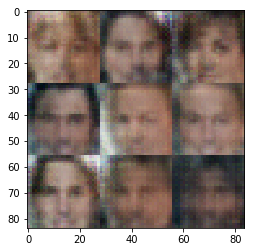

Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 7.2714
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 6.8781
Epoch 1/1... Discriminator Loss: 0.0046... Generator Loss: 6.3467
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 4.8388
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 4.4829
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 5.0161
Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 5.4774
Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 7.0875
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 3.6808


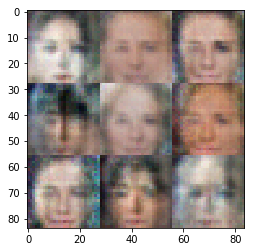

Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 6.2088
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 6.0077
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 2.5921
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 7.5640
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 6.1996
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 0.1025... Generator Loss: 2.7233
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 5.2725
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 7.1934
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 6.8933


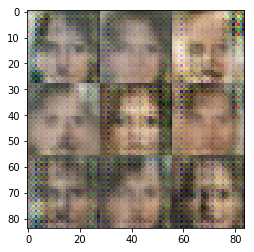

Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 6.2660
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 3.0474
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 5.6039
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 7.7538
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 7.1286
Epoch 1/1... Discriminator Loss: 3.1390... Generator Loss: 5.9269
Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 4.9240
Epoch 1/1... Discriminator Loss: 0.0587... Generator Loss: 5.1804
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.4754


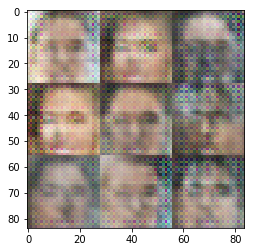

Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 7.2677
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.5851
Epoch 1/1... Discriminator Loss: 0.0317... Generator Loss: 3.7511
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 0.3058... Generator Loss: 4.1615
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 6.0682
Epoch 1/1... Discriminator Loss: 0.0158... Generator Loss: 4.9838
Epoch 1/1... Discriminator Loss: 0.1104... Generator Loss: 2.8161


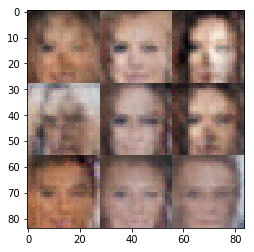

Epoch 1/1... Discriminator Loss: 0.1476... Generator Loss: 4.5828
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 5.2297
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 3.6260
Epoch 1/1... Discriminator Loss: 0.0492... Generator Loss: 3.2604
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 7.4587
Epoch 1/1... Discriminator Loss: 0.0929... Generator Loss: 5.6960
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.4408
Epoch 1/1... Discriminator Loss: 0.0066... Generator Loss: 6.3727
Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 4.1962
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 1.1724


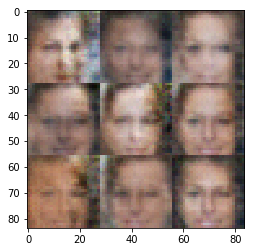

Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 5.5525
Epoch 1/1... Discriminator Loss: 0.1152... Generator Loss: 2.3240
Epoch 1/1... Discriminator Loss: 0.3241... Generator Loss: 1.5441
Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 5.2737
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 6.5533
Epoch 1/1... Discriminator Loss: 2.5842... Generator Loss: 0.0944
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 5.3645
Epoch 1/1... Discriminator Loss: 0.0299... Generator Loss: 5.9127
Epoch 1/1... Discriminator Loss: 0.1261... Generator Loss: 5.0006


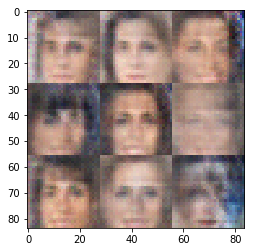

Epoch 1/1... Discriminator Loss: 0.0314... Generator Loss: 5.8277
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 5.4112
Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 8.0342
Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 7.1169
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 7.3223
Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 5.2976
Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 6.1495
Epoch 1/1... Discriminator Loss: 0.1372... Generator Loss: 2.5279
Epoch 1/1... Discriminator Loss: 0.0830... Generator Loss: 2.9738


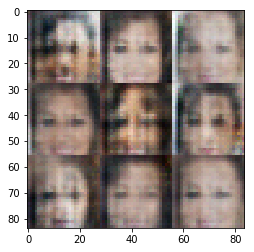

Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 0.2715... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 6.0578
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 0.2520... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 8.3671
Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 1.9779
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 8.5116
Epoch 1/1... Discriminator Loss: 0.1209... Generator Loss: 2.2845


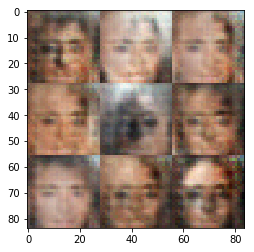

Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 3.4313
Epoch 1/1... Discriminator Loss: 2.3034... Generator Loss: 0.1226
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 2.6432... Generator Loss: 0.0922
Epoch 1/1... Discriminator Loss: 0.0903... Generator Loss: 3.0159
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 1.8713
Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 2.8984


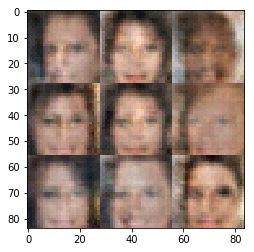

Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 1.2107
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 7.1023
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 6.0848
Epoch 1/1... Discriminator Loss: 0.2471... Generator Loss: 2.4475
Epoch 1/1... Discriminator Loss: 0.1423... Generator Loss: 2.1905
Epoch 1/1... Discriminator Loss: 0.0972... Generator Loss: 3.0988
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 7.4823
Epoch 1/1... Discriminator Loss: 0.2925... Generator Loss: 5.5004
Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 4.7711


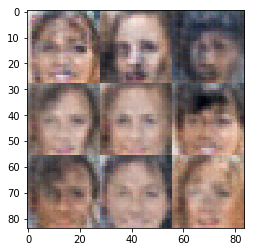

Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 2.6005... Generator Loss: 6.1785
Epoch 1/1... Discriminator Loss: 0.1355... Generator Loss: 2.4025
Epoch 1/1... Discriminator Loss: 0.3063... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 2.0456
Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 4.3968
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 1.4868
Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 2.7290
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 2.8598


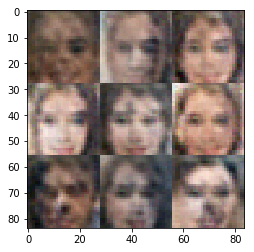

Epoch 1/1... Discriminator Loss: 2.3964... Generator Loss: 0.1173
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 0.2648... Generator Loss: 1.6612
Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 5.5096
Epoch 1/1... Discriminator Loss: 0.3509... Generator Loss: 5.3718
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 3.4469
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.3789
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.2935
Epoch 1/1... Discriminator Loss: 0.3242... Generator Loss: 1.4628


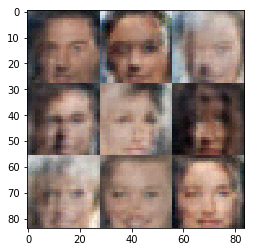

Epoch 1/1... Discriminator Loss: 0.2044... Generator Loss: 3.0364
Epoch 1/1... Discriminator Loss: 0.2317... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 3.7188... Generator Loss: 0.0367
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 2.2547
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 2.6482... Generator Loss: 0.1126
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 0.2792... Generator Loss: 1.7165


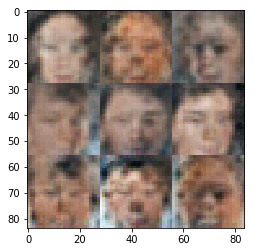

Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 3.4995
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 2.4919... Generator Loss: 0.1117
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 1.4605
Epoch 1/1... Discriminator Loss: 0.2315... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 0.0565... Generator Loss: 3.3641
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 1.9911
Epoch 1/1... Discriminator Loss: 2.4919... Generator Loss: 0.1061


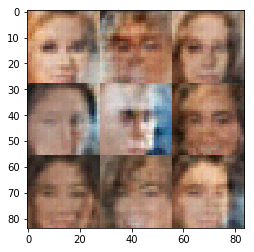

Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.8228
Epoch 1/1... Discriminator Loss: 0.2812... Generator Loss: 2.8634
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 0.2862... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 1.1973
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 4.8593
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 0.9586


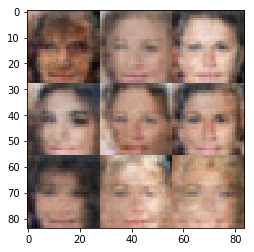

Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 0.2148... Generator Loss: 1.8692
Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 5.1362
Epoch 1/1... Discriminator Loss: 3.9748... Generator Loss: 0.0261
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 5.5968
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 0.2613... Generator Loss: 1.6824


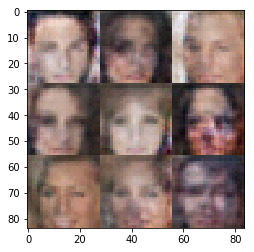

Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 0.0905... Generator Loss: 2.9810
Epoch 1/1... Discriminator Loss: 0.2758... Generator Loss: 3.6745
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 3.6610
Epoch 1/1... Discriminator Loss: 3.6710... Generator Loss: 7.6127
Epoch 1/1... Discriminator Loss: 0.2992... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 0.2270... Generator Loss: 2.1597
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 4.6161
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 1.0481


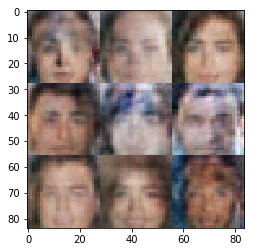

Epoch 1/1... Discriminator Loss: 1.7596... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 4.0726
Epoch 1/1... Discriminator Loss: 0.2273... Generator Loss: 2.0828
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 1.9169
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 2.4162... Generator Loss: 0.1240
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 0.2919
Epoch 1/1... Discriminator Loss: 0.3007... Generator Loss: 1.4791


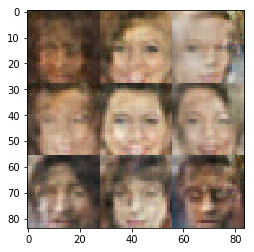

Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 1.6183
Epoch 1/1... Discriminator Loss: 0.2645... Generator Loss: 2.0392
Epoch 1/1... Discriminator Loss: 0.3391... Generator Loss: 1.5473
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 2.9463
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 5.8516
Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 4.5742
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 1.0362


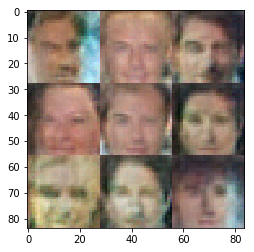

Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 0.2767... Generator Loss: 1.7938
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 0.3324... Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 0.0770... Generator Loss: 3.0384
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 1.8766
Epoch 1/1... Discriminator Loss: 0.1720... Generator Loss: 3.7157


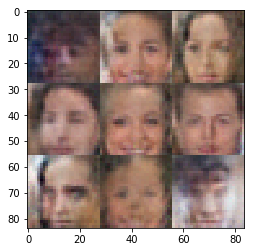

Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 0.2729... Generator Loss: 3.1852
Epoch 1/1... Discriminator Loss: 2.4035... Generator Loss: 0.1252
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 4.1762
Epoch 1/1... Discriminator Loss: 0.3138... Generator Loss: 1.6011
Epoch 1/1... Discriminator Loss: 0.0815... Generator Loss: 4.5060
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 0.2147... Generator Loss: 2.2915


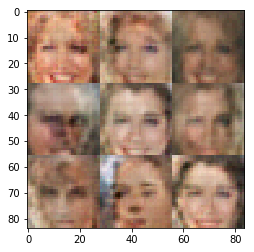

Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 0.2485... Generator Loss: 1.9378
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 0.2907... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 1.9272
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 3.6082
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 6.2255
Epoch 1/1... Discriminator Loss: 0.2918... Generator Loss: 1.5619


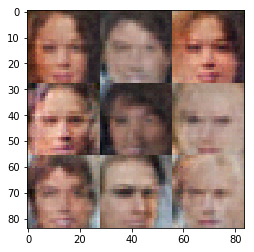

Epoch 1/1... Discriminator Loss: 0.1420... Generator Loss: 2.5083
Epoch 1/1... Discriminator Loss: 3.9812... Generator Loss: 7.2857
Epoch 1/1... Discriminator Loss: 0.2219... Generator Loss: 2.2132
Epoch 1/1... Discriminator Loss: 0.2614... Generator Loss: 1.7934
Epoch 1/1... Discriminator Loss: 0.1004... Generator Loss: 3.3638
Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 5.8012... Generator Loss: 7.9930
Epoch 1/1... Discriminator Loss: 0.2580... Generator Loss: 1.7877
Epoch 1/1... Discriminator Loss: 0.3159... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.1304... Generator Loss: 2.8506


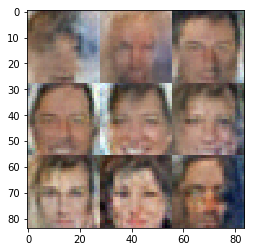

Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 2.6697
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 2.2789
Epoch 1/1... Discriminator Loss: 1.7737... Generator Loss: 0.2449
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 2.3537
Epoch 1/1... Discriminator Loss: 0.1242... Generator Loss: 2.3545
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 4.9237
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 3.4987
Epoch 1/1... Discriminator Loss: 0.2105... Generator Loss: 1.8499


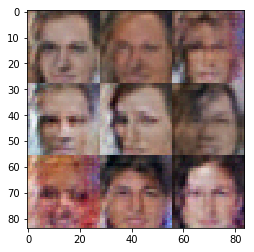

Epoch 1/1... Discriminator Loss: 0.0581... Generator Loss: 4.4932
Epoch 1/1... Discriminator Loss: 0.2505... Generator Loss: 1.8276
Epoch 1/1... Discriminator Loss: 0.2448... Generator Loss: 3.0049
Epoch 1/1... Discriminator Loss: 0.2478... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 0.1730... Generator Loss: 2.2600
Epoch 1/1... Discriminator Loss: 0.2854... Generator Loss: 1.7191
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 4.0616
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 3.0200
Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 5.1559
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 1.0894


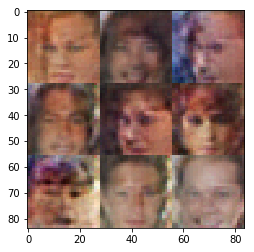

Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 3.0984
Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 1.7244
Epoch 1/1... Discriminator Loss: 0.2125... Generator Loss: 2.3423
Epoch 1/1... Discriminator Loss: 0.2562... Generator Loss: 2.3463
Epoch 1/1... Discriminator Loss: 2.2212... Generator Loss: 0.1790
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.9156... Generator Loss: 0.1978
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.2687... Generator Loss: 1.6890


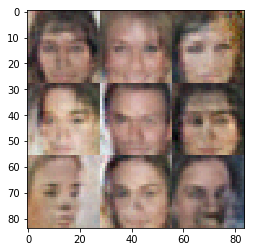

Epoch 1/1... Discriminator Loss: 1.6296... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 0.2699... Generator Loss: 1.7369
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 5.7317
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 2.2307


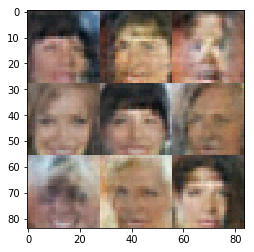

Epoch 1/1... Discriminator Loss: 0.2606... Generator Loss: 1.8134
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 4.6051
Epoch 1/1... Discriminator Loss: 2.0861... Generator Loss: 5.8109
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.3200
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 1.2648
Epoch 1/1... Discriminator Loss: 0.1679... Generator Loss: 2.0648
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 5.0121


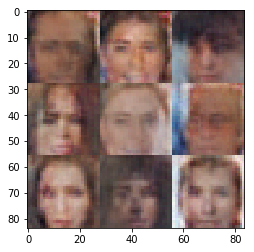

Epoch 1/1... Discriminator Loss: 0.2120... Generator Loss: 1.7934
Epoch 1/1... Discriminator Loss: 0.1636... Generator Loss: 2.4691
Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 2.2423
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 2.0662
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 1.3556
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 1.4999


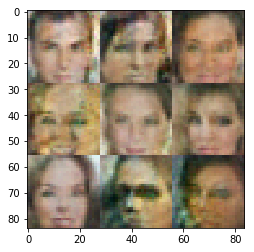

Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.2261
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 2.8618
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 0.0922... Generator Loss: 5.3027
Epoch 1/1... Discriminator Loss: 0.2965... Generator Loss: 1.6390
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 5.2881
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 1.2777
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 1.0656


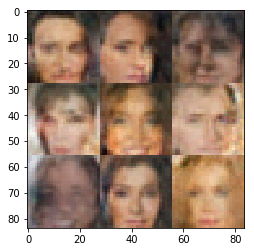

Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.2556
Epoch 1/1... Discriminator Loss: 0.1333... Generator Loss: 2.4158
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 6.8906
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 6.7088
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 4.6036


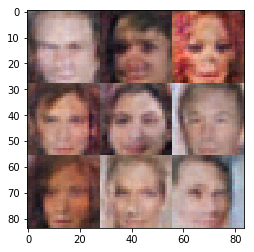

Epoch 1/1... Discriminator Loss: 0.2307... Generator Loss: 1.8647
Epoch 1/1... Discriminator Loss: 0.2513... Generator Loss: 1.6429
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 0.9682


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.